# House Prices: Advanced Regression Techniques

1. Acquire the data
2. Explore the data
3. Engineer and transform the features and the target variable
4. Build a model
5. Make and submit predictions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use(style='ggplot')

import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [2]:
print ("Train data shape:", train.shape)
print ("Test data shape:", test.shape)

Train data shape: (1460, 81)
Test data shape: (1459, 80)


In [3]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


For this competition, we were tasked with predicting housing prices of residences in Ames, Iowa. Our training data has 1460 houses (i.e., observations) accompanied by 79 attributes (i.e., features, variables, or predictors) and the sales price for each house. Our testing set included 1459 houses with the same 79 attributes, but sales price was not included as this was our target variable.

Looking at the dataset, there's lots of NaN's, potential for outliers, and lots of features. This dataset roughly matches what I expect to see with clients working with Dito - usually, data is not necessarily clean. You have to do a lot of data preprocessing and feature engineering.


Real world data are generally
1. Incomplete: lacking attribute values, lacking certain attributes of interest, or containing only aggregate data
2. Noisy: containing errors or outliers
3. Inconsistent: containing discrepancies in codes or names

Tasks in data preprocessing
1. Data cleaning: fill in missing values, smooth noisy data, identify or remove outliers, and resolve inconsistencies.
2. Data integration: using multiple databases, data cubes, or files.
3. Data transformation: normalization and aggregation.
4. Data reduction: reducing the volume but producing the same or similar analytical results.
5. Data discretization: part of data reduction, replacing numerical attributes with nominal ones.


Let's look at some of the our target variable: Sale Price and some of the features.


In [4]:
train.SalePrice.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

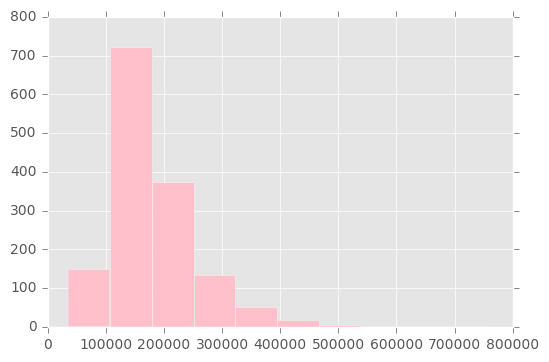

In [5]:
plt.hist(train.SalePrice, color='pink')
plt.show()

Let's make the data look more like a bell curve (normalized).' Why do we need to do this? Lots of reasons, but there's a lot of statistical principles that apply to a variables which have a bell curve or bell shaped distribution. Our target variable (the one we are trying to predict) has a right skewed distribution - which means that there is a cluster values to the left.

We can make a cluster of values towards the middle to fit a bell curve by using a log transform operation

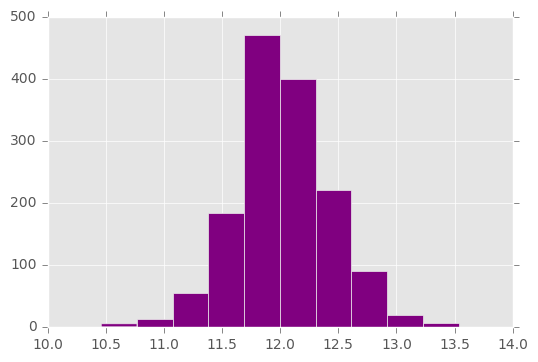

In [6]:
target = np.log(train.SalePrice)
plt.hist(target, color='purple')
plt.show()

Let's look at the features.

In [7]:
numeric_features = train.select_dtypes(include=[np.number])
numeric_features.dtypes

Id                 int64
MSSubClass         int64
LotFrontage      float64
LotArea            int64
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
MasVnrArea       float64
BsmtFinSF1         int64
BsmtFinSF2         int64
BsmtUnfSF          int64
TotalBsmtSF        int64
1stFlrSF           int64
2ndFlrSF           int64
LowQualFinSF       int64
GrLivArea          int64
BsmtFullBath       int64
BsmtHalfBath       int64
FullBath           int64
HalfBath           int64
BedroomAbvGr       int64
KitchenAbvGr       int64
TotRmsAbvGrd       int64
Fireplaces         int64
GarageYrBlt      float64
GarageCars         int64
GarageArea         int64
WoodDeckSF         int64
OpenPorchSF        int64
EnclosedPorch      int64
3SsnPorch          int64
ScreenPorch        int64
PoolArea           int64
MiscVal            int64
MoSold             int64
YrSold             int64
SalePrice          int64
dtype: object

In [8]:
cat_features = train.select_dtypes(exclude=[np.number])
cat_features.dtypes

MSZoning         object
Street           object
Alley            object
LotShape         object
LandContour      object
Utilities        object
LotConfig        object
LandSlope        object
Neighborhood     object
Condition1       object
Condition2       object
BldgType         object
HouseStyle       object
RoofStyle        object
RoofMatl         object
Exterior1st      object
Exterior2nd      object
MasVnrType       object
ExterQual        object
ExterCond        object
Foundation       object
BsmtQual         object
BsmtCond         object
BsmtExposure     object
BsmtFinType1     object
BsmtFinType2     object
Heating          object
HeatingQC        object
CentralAir       object
Electrical       object
KitchenQual      object
Functional       object
FireplaceQu      object
GarageType       object
GarageFinish     object
GarageQual       object
GarageCond       object
PavedDrive       object
PoolQC           object
Fence            object
MiscFeature      object
SaleType        

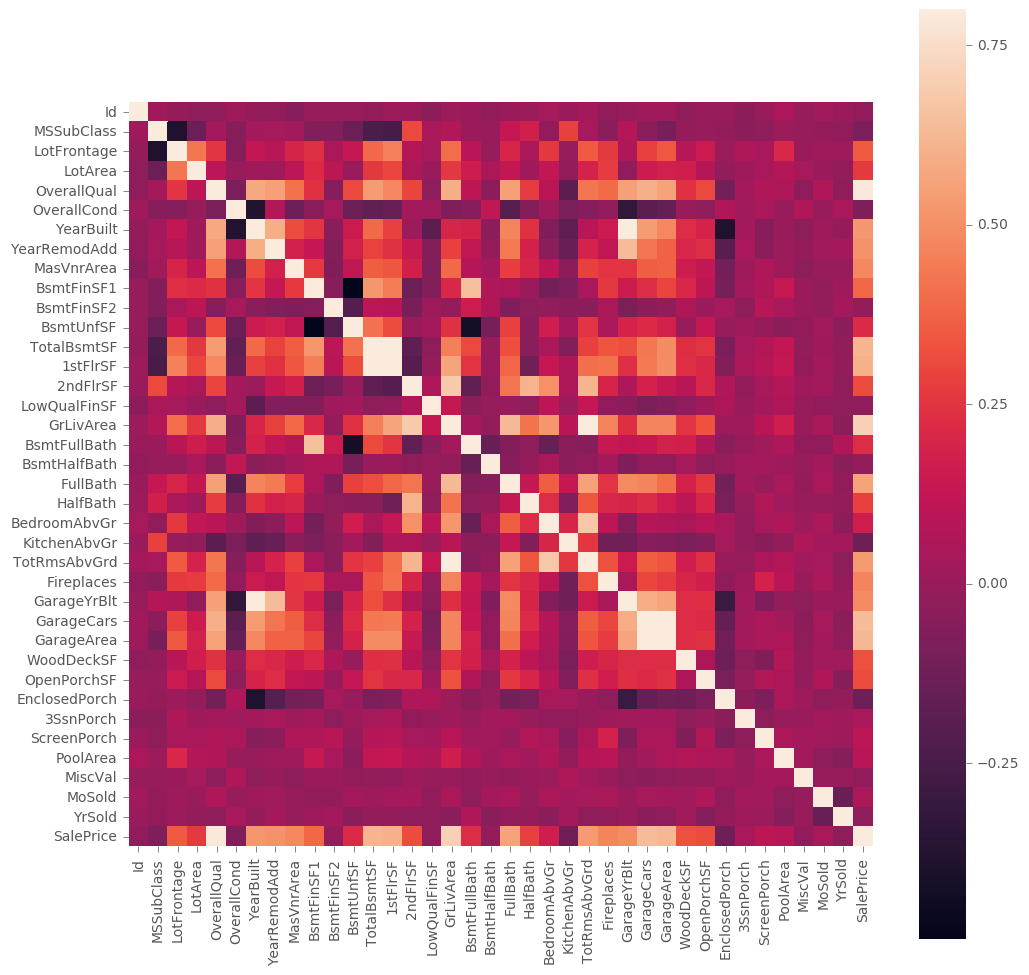

In [9]:
corrmat = train.corr()
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(corrmat, vmax=.8, square=True);

f

In [10]:
total = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageCond,81,0.055479
GarageType,81,0.055479
GarageYrBlt,81,0.055479
GarageFinish,81,0.055479


In [11]:
missing_data.shape

(81, 2)

Strong correlation = paler area. If we think about these variables, we can conclude that they give almost the same information

Red correlation = little to no impact on Sale Price. If you look at the last column, you could see features like enclosed porch. Porches are important to me, but it's one of the last things I look at.

So what jumps out at me: some features are not as important as other features.

If we look at only a few features, we might be able to get a good prediction.

In the real world, this means we hope to do more with less.

When you are building a pipeline, you don't want to spend valuable developer hours optimizing for collecting information that may not contribute much to the final result



In [12]:
corr = numeric_features.corr()

print (corr['SalePrice'].sort_values(ascending=False)[0:18], '\n')

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
GarageYrBlt     0.486362
MasVnrArea      0.477493
Fireplaces      0.466929
BsmtFinSF1      0.386420
LotFrontage     0.351799
WoodDeckSF      0.324413
2ndFlrSF        0.319334
Name: SalePrice, dtype: float64 



'OverallQual', 'GrLivArea' and 'TotalBsmtSF' are strongly correlated with 'SalePrice'.

'GarageCars' is similar to  'GarageArea' are also some of the most strongly correlated variables. So let's only keep one of them.

1stFlrSF is also good.

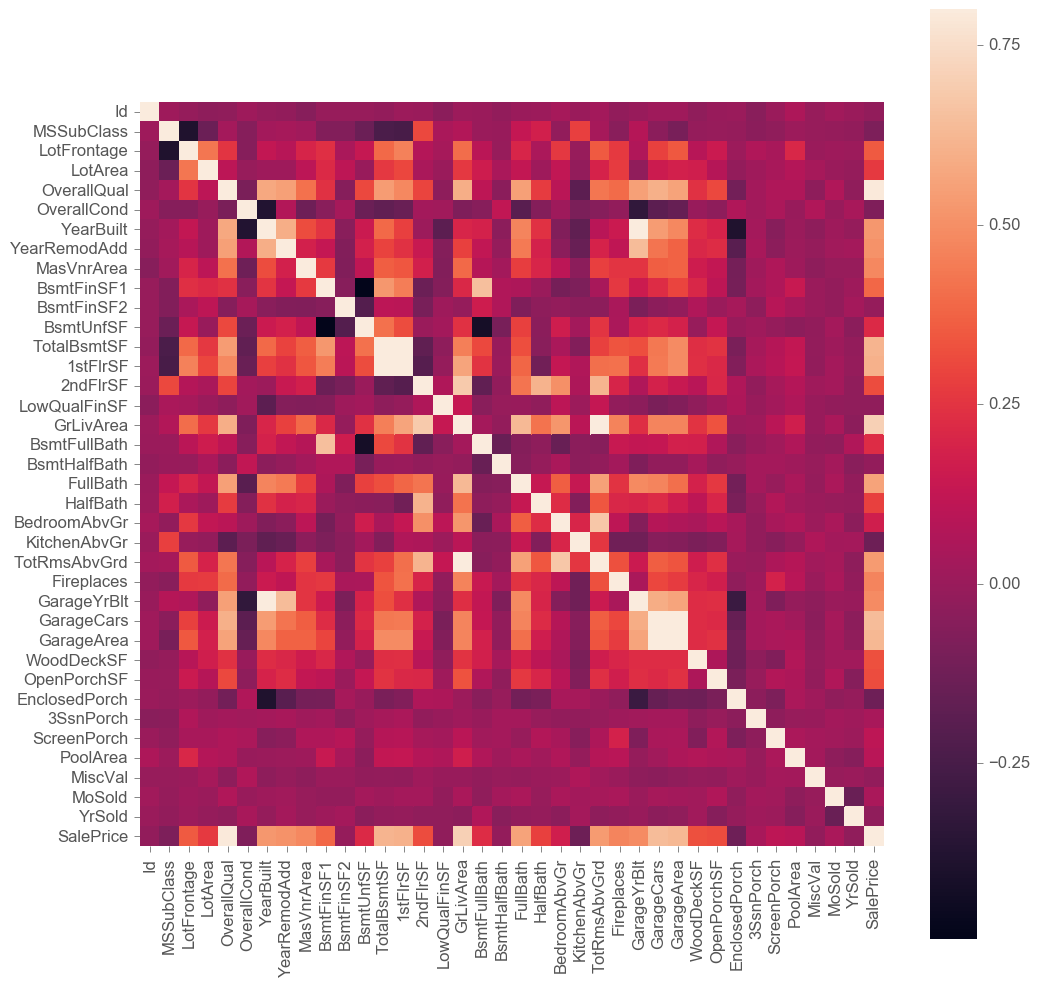

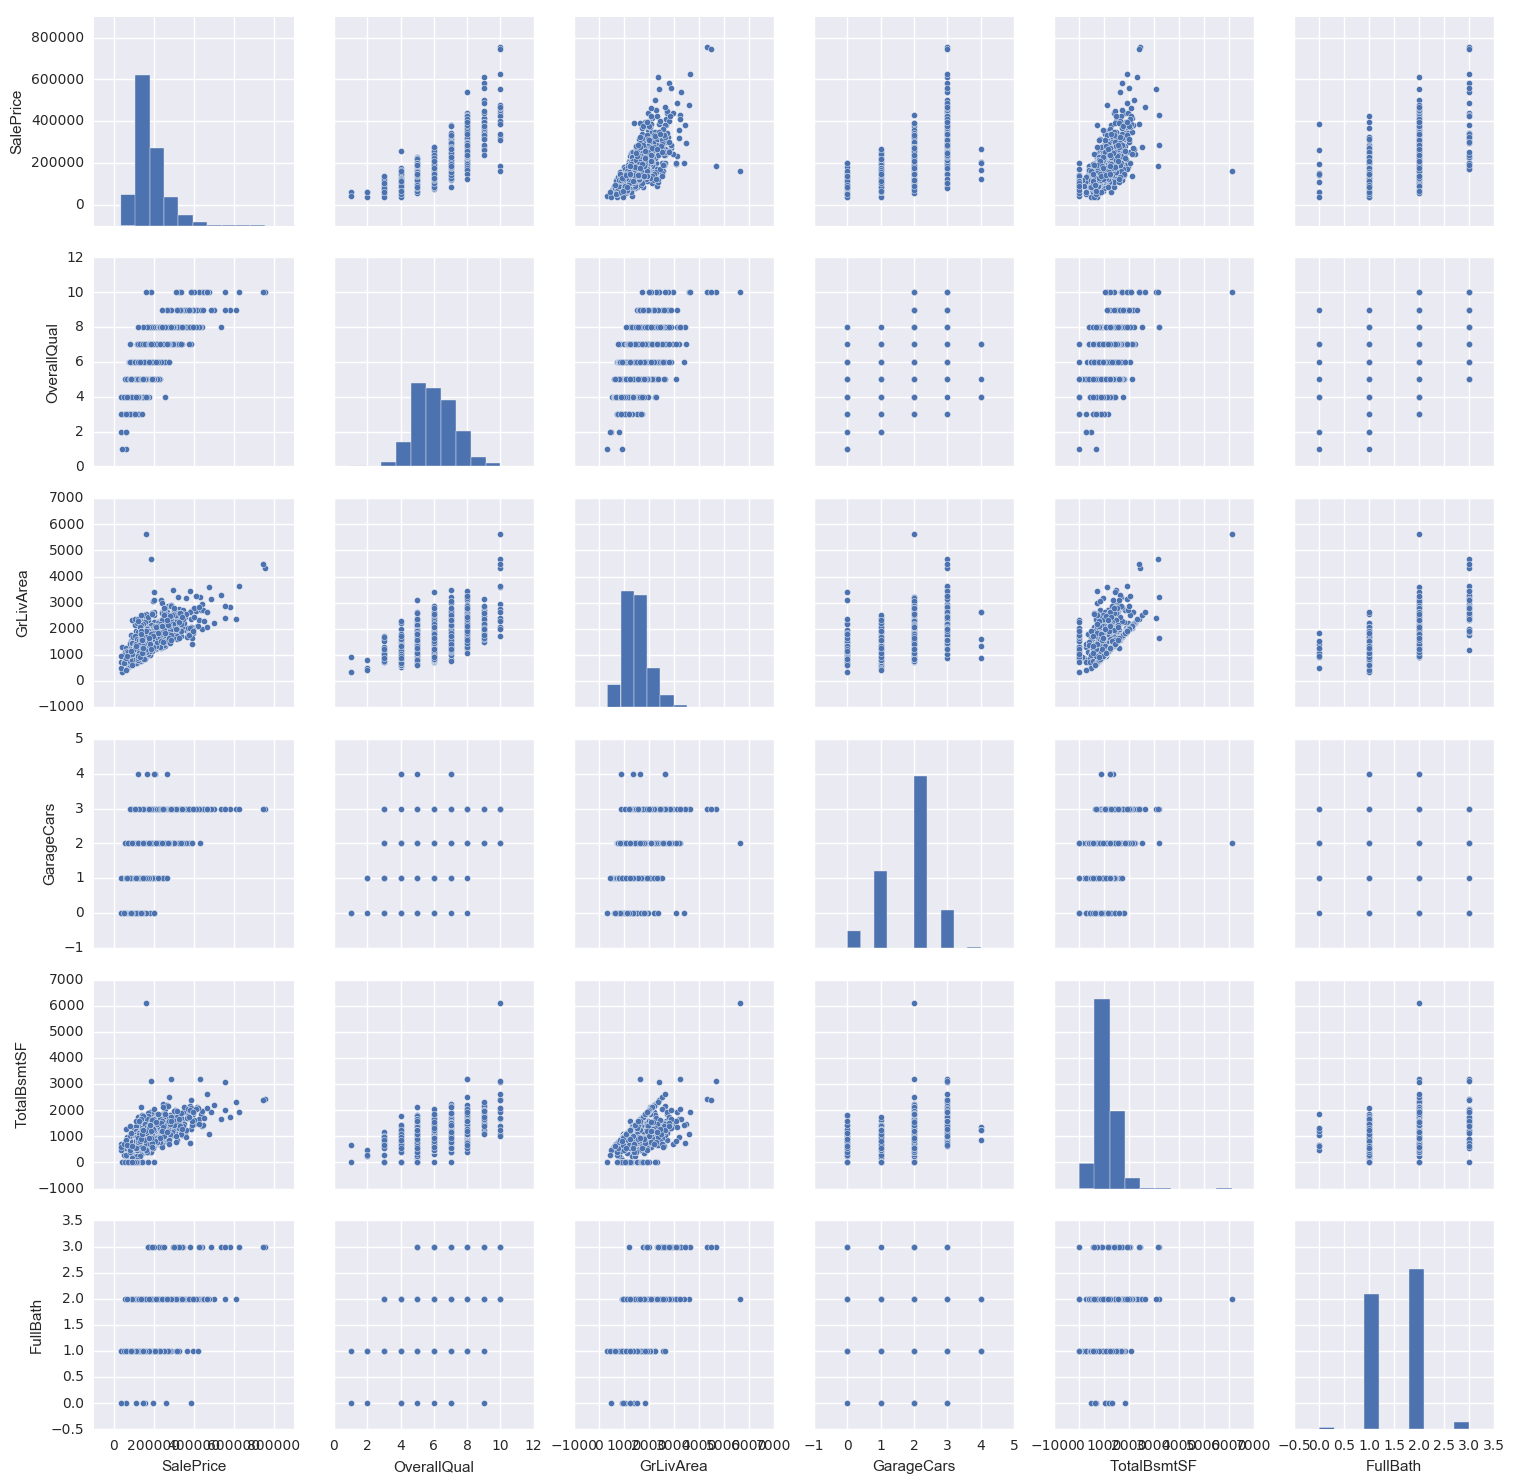

In [13]:
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath']
sns.pairplot(train[cols], size = 2.5)
plt.show()

Okay, so we found a few features that are good.

What do we do with the rest of the features?

Do we try to fix the missing data, substituting values?

Do we get rid of them?

How do we know the values we substitute are correct?

We also have to make sure that if we do delete any data, it's not data that's highly correlated to the Sale Price.

PoolQC seems to be a good candidate because there's a lot of missing data + there's a low chance it affects the final price + fits what my intution tells me. 

Another set of candidates that can be deleted relates to our heatmap, if two sets of candidates are correlated and both of them impact the Sales Price, we can delete just one from the pair.

In [14]:
new_train = train.drop((missing_data[missing_data['Total'] > 1]).index,1)

In [15]:
new_train.shape

(1460, 63)

What about outliers? Do we have them? Do we delete them?

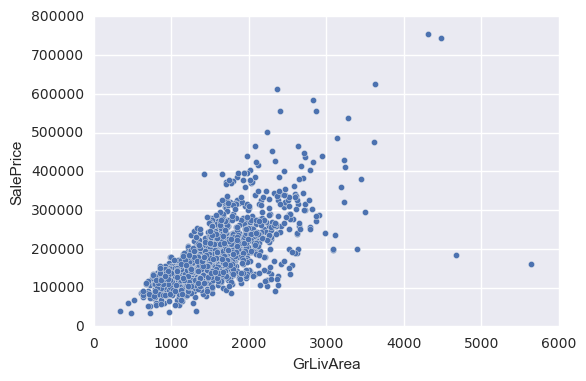

In [16]:
var = 'GrLivArea'
data = pd.concat([new_train['SalePrice'], new_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000))
plt.show()

In [17]:
new_train = new_train.drop(['SalePrice', 'Id', 'Electrical'], axis=1)

new_train.shape

(1460, 60)

We could use a technique called one-hot encoding to change the categorical variables into numerical ones.

One-hot encoding is a technique which will transform categorical data into numbers so the model can understand whether or not a particular observation falls into one category or another.

In [18]:
cat_features = new_train.select_dtypes(exclude=[np.number])
cat_features.dtypes

MSZoning         object
Street           object
LotShape         object
LandContour      object
Utilities        object
LotConfig        object
LandSlope        object
Neighborhood     object
Condition1       object
Condition2       object
BldgType         object
HouseStyle       object
RoofStyle        object
RoofMatl         object
Exterior1st      object
Exterior2nd      object
ExterQual        object
ExterCond        object
Foundation       object
Heating          object
HeatingQC        object
CentralAir       object
KitchenQual      object
Functional       object
PavedDrive       object
SaleType         object
SaleCondition    object
dtype: object

In [19]:
df_train = pd.get_dummies(new_train)

In [20]:
cat_features = df_train.select_dtypes(include=[np.number])

In [21]:
y = np.log(train.SalePrice)
X = df_train

In [22]:
X.shape

(1460, 215)

Let's divide our training set into 2 sets: another training set and another testing set.'

In [24]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
                                    X, y, random_state=42, test_size=.33)

In [25]:
from sklearn import linear_model

lr = linear_model.LinearRegression()

In [26]:
model = lr.fit(X_train, y_train)

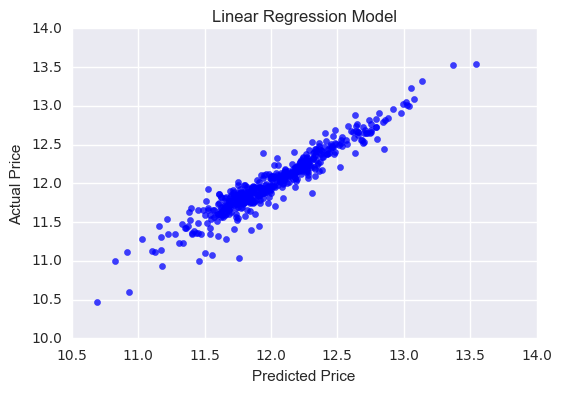

In [27]:
predictions = model.predict(X_test)

actual_values = y_test
plt.scatter(predictions, actual_values, alpha=.75,
            color='b') #alpha helps to show overlapping data
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('Linear Regression Model')
plt.show()

In [28]:
submission = pd.DataFrame()
submission['Id'] = test.Id

In [51]:
test.shape

(1459, 60)

In [52]:
test = test.drop((missing_data[missing_data['Total'] > 1]).index,1)

ValueError: labels ['PoolQC' 'MiscFeature' 'Alley' 'Fence' 'FireplaceQu' 'LotFrontage'
 'GarageCond' 'GarageType' 'GarageYrBlt' 'GarageFinish' 'GarageQual'
 'BsmtExposure' 'BsmtFinType2' 'BsmtFinType1' 'BsmtCond' 'BsmtQual'
 'MasVnrArea' 'MasVnrType'] not contained in axis

In [50]:
test = test.drop(['Electrical', 'Id'], axis=1)

ValueError: labels ['Electrical' 'Id'] not contained in axis

In [34]:
new_train.shape

(1460, 60)

In [36]:
q = pd.get_dummies(test)

In [49]:
def add_missing_dummy_columns( d, columns ):
    missing_cols = set( columns ) - set( d.columns )
    for c in missing_cols:
        d[c] = 0
        
add_missing_dummy_columns( q, list(df_train.columns) )

(1460, 215)

In [68]:
q = q.fillna(0)

predictions = model.predict(q)

In [69]:
final_predictions = np.exp(predictions)

In [70]:
final_predictions

array([ 53284.55659106,  46651.46471208,  68414.76898214, ...,
        45438.02973799,  50942.03800489,  96771.5942546 ])

In [71]:
submission['SalePrice'] = final_predictions
submission.head()

,Id,SalePrice
0,1461,53284.556591
1,1462,46651.464712
2,1463,68414.768982
3,1464,68091.709070
4,1465,190548.978944


In [72]:
submission.to_csv('submission_final.csv', index=False)